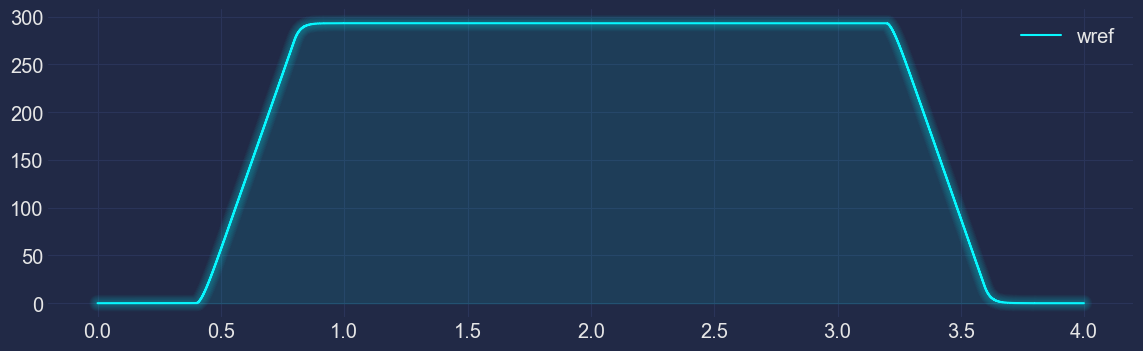

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
import math
import random

plt.style.use("cyberpunk")

sign = lambda x: math.copysign(1, x)

def cria_func(x,x2,A1,A2,intervalo):
    passo = ((x-x2))
    a = (A1-A2)/passo
    b = A2-a*x2
    vet = []
    
    for k in np.arange(x,x2,intervalo):
        vet.append(a*(k)+b)
    return vet

def FEM_sqr(ang):
    pi = math.pi
    ang=ang%(2*pi)
    if ang < (90/180)*pi:
        return 1
    elif ang < (150/180)*pi:
        return ang*-6/pi+4
    elif ang < (270/180)*pi:
        return -1
    elif ang < (330/180)*pi:
        return ang*(6/(pi)) -10
    else:
        return 1

def DFEM_sqr(ang):
    pi = math.pi
    ang=ang%(2*pi)
    if ang < (90/180)*pi:
        return 0
    elif ang < (150/180)*pi:
        return -6/pi
    elif ang < (270/180)*pi:
        return 0
    elif ang < (330/180)*pi:
        return 6/pi
    else:
        return 0

def FEM_sin(ang):
    pi = math.pi
    ang=ang%(2*pi)
    pi = math.pi
    return math.sin(ang+pi/3.0)
    
def DFEM_sin(ang):
    pi = math.pi
    ang=ang%(2*pi)
    return math.cos(ang + math.pi/3.0)

#!Parametros do motor.
R           = 0.090
L           = 0.01*pow(10,-3)
J           = 0.01*pow(10,-3)
BV          = 0.062*pow(10,-3)
Ke          = 0.31
p           = 14
Pp          = p/2
M           = 0
Tmax        = 12
Rmax        = 3500
Rmax_rad    = 3500*0.1047
rvolt       = Tmax/Rmax_rad
cmax        = 13
Tl          = 0.0667

#! Parametros da simulação
E           = Tmax
Nbits_pwm   = 8
P           = pow(2,Nbits_pwm)
Vmax        = Tmax

EAD         = 3
Nbits_ad    = 12
Q_ad        = pow(2,Nbits_ad)
offsetCS    = 0.5
K_ad        = EAD/Rmax
K_ad_current= EAD/cmax

#! Controlador
kp          = 40
ki          = 3
kd          = 6

kp2         = 0.1
ki2         = 0.0018
kd2         = 0.001

kp3         = 0.1
ki3         = 0.0018
kd3         = 0.001

ui          = 0
ui2         = 0
ui3         = 0

ud          = 0
ud2         = 0
ud3         = 0

ui_kal          = 0
ui2_kal         = 0
ui3_kal         = 0

ud_kal          = 0
ud2_kal         = 0
ud3_kal         = 0

clarke      = np.array([[math.sqrt(1/2), math.sqrt(1/2),   math.sqrt(1/2)],
                        [1,              -1/2,             -1/2],
                        [0,              math.sqrt(3)/2,   -math.sqrt(3)/2]])

clarke     = np.multiply(clarke,math.sqrt(2/3))
inversor   = np.array([[2/3,       -1/3,        -1/3],
                        [-1/3,      2/3,         -1/3],
                        [-1/3,      -1/3,        2/3]])

inv_clarke = np.linalg.inv(clarke)

#! Motor
Ai         = np.array([[-R/(L-M),    0,           0,           -Pp*Ke/(L-M),         0],
                        [0,           -R/(L-M),    0,           -Pp*Ke/(L-M),         0],
                        [0,           0,           -R/(L-M),    -Pp*Ke/(L-M),         0],
                        [Pp*Ke/J,     Pp*Ke/J,     Pp*Ke/J,     -BV/J,                0],
                        [0,           0,           0,           Pp,                   0]])


B          = np.array([[1/(L-M),      0,           0,           0],
                        [0,            1/(L-M),     0,           0],
                        [0,            0,           1/(L-M),     0],
                        [0,            0,           0,           -1/J],
                        [0,            0,           0,           0]])

#! Parametros simulação
Tadc    = 1*10**-3
Tsim    = 4
pi      = math.pi

adc_to_rpm = Rmax/(2**Nbits_ad)
rpm_to_rad = 2*pi/60

x       = np.arange(0,Tsim,Tadc)
N       = len(x)

Va      = np.zeros(N)
Vb      = np.zeros(N)
Vc      = np.zeros(N)

X       = np.zeros((5,N))
Valpha_beta    = np.zeros((3,N))
Vqd     = np.zeros((3,N))

theta=0
theta0=0
w = 0
wr = 0
wn = Rmax_rad
wn2 = wn*0.8

wref = cria_func(0,0.1*Tsim,0,0,Tadc) + cria_func(0.1*Tsim+Tadc,0.2*Tsim,0,wn2,Tadc) + cria_func(0.2*Tsim+Tadc,0.8*Tsim,wn2,wn2,Tadc) + cria_func(0.8*Tsim+Tadc,0.9*Tsim,wn2,0,Tadc) + cria_func(0.9*Tsim+Tadc,Tsim+2.5*Tadc,0,0,Tadc) + [0]
for k in range(1,len(wref)):
    wref[k] = 0.96*wref[k-1] + 0.04*wref[k]

f=plt.figure(1)
f.set_size_inches(14, 4)
plt.step(x,wref,label="wref")
plt.grid(True)
plt.legend()
plt.legend(fontsize="x-large")
plt.xticks(fontsize="x-large")
plt.yticks(fontsize="x-large")
mplcyberpunk.add_glow_effects()
plt.savefig('Resultados/referencia.pdf')

# CONTROL V/F